In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

# Esteganografia

# Ocultar mensaje dentro de imagen

## Encoding
Idea: la imagen está compuesta por nxm pixeles, y cada uno está representado por 3 valores del 0 al 255 (tres canales: R, G, B).
Para lograr introducir un mensaje sin una distorsión notoria de la imagen la idea es representar un caracter cada 3 pixeles de la siguiente forma: 

1) Convertimos el caracter ascii a su entero correspondiente (entra en 8 bits)
2) Convertimos el entero a binario
3) Tres pixeles están representado por 3*3=9 valores, entonces vamos a usar los primeros 8 para representar los 8 bits del caracter determinando si se trata de un 0 o un 1 dependiendo si el valor que toma el pixel en ese canal es par o impar respectivamente. El 9no valor lo usamos para determinar si el mensaje finaliza o no en caso de que sea par o impar respectivamente

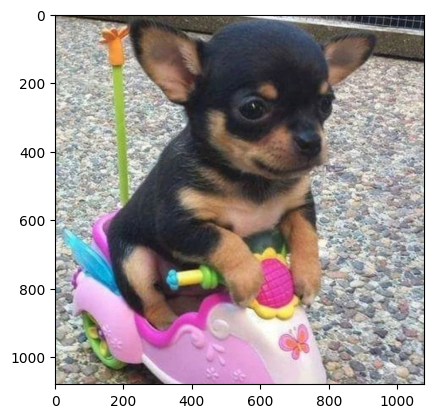

La cantidad máxima de caracteres que puede tener nuestro mensaje es: 388800


In [2]:
# Cargamos foto
img = cv2.imread("img1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# Max longitud del mensaje
max_len = math.floor(img.shape[0]*img.shape[1]/3)
print(f"La cantidad máxima de caracteres que puede tener nuestro mensaje es: {max_len}")

In [3]:
# Funcion que encodea el msj
def update_pixel_channel(pixel_ch:int, bit:bool):
    if not bit and pixel_ch%2!=0: return pixel_ch-1
    elif bit and pixel_ch%2==0: return pixel_ch+1
    return pixel_ch
        
def update_last_pixel_channel(pixel_ch:int, end:bool):
    if end and pixel_ch%2!=0: return pixel_ch-1
    elif not end and pixel_ch%2==0: return pixel_ch+1
    return pixel_ch
    
def encode_msg(msg, img):
    max_len = math.floor(img.shape[0]*img.shape[1]/3)
    
    if len(msg) > max_len:
        print("Error: message is too long")
        return
    
    np_img = np.array(img)
    pixels = np_img.reshape((np_img.shape[0]*np_img.shape[1],3))
    
    # Recorremos de a 3 pixeles
    for idx_pixel_set in range(math.floor(len(pixels)/3)):
        if idx_pixel_set == len(msg):
            break
        
        char = msg[idx_pixel_set]
        char_int = ord(char)
        char_bin = f"{char_int:8b}"

        # Recorremos los 3 pixeles del set
        for i in range(3):
            # Recorremos los 3 canales de cada pixel
            for j in range(3):
                curr_px_ch = pixels[idx_pixel_set*3 + i, j]
                idx_value = 3*i+j
                
                #Si es el noveno valor, chequeamos si el mensaje termina, si no es el noveno seteamos el valor
                #del del canal en cuestion como par o impar segun si corresponde un 0 o 1 respectivamente
                if idx_value == 8:
                    pixels[idx_pixel_set*3 + i, j] = update_last_pixel_channel(curr_px_ch, idx_pixel_set==len(msg)-1)
                else:
                    curr_bit = char_bin[3*i+j]
                    pixels[idx_pixel_set*3 + i, j] = update_pixel_channel(curr_px_ch, int(curr_bit) if curr_bit!=" " else 0)
    
    return pixels.reshape(img.shape)

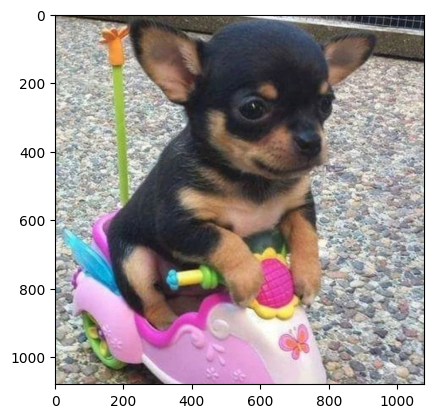

In [4]:
msg = "Roses are red, Violets are blue\nUnexpected ' { ' on line 32."
encoded_msg = encode_msg(msg,img.copy())
plt.imshow(encoded_msg)
plt.show()

## Decoding

In [5]:
#Funcion que decodifica el mensaje
def decode_msg(img):
    np_img = np.array(img)
    pixels = np_img.reshape((np_img.shape[0]*np_img.shape[1],3))
    
    msg = ''
    done=False
    # Recorremos de a 3 pixeles
    curr_char_bin = ''

    for i_px,pixel in enumerate(pixels):
        if done: break
        for i_ch,channel in enumerate(pixel):
            if (i_px+1)%3==0 and i_ch==2:
                if channel%2==0: done=True
                else: pass
            else:
                if channel%2==0: curr_char_bin+='0'
                else: curr_char_bin+='1'
        if (i_px+1)%3==0:
            msg+=chr(int(curr_char_bin,2))
            curr_char_bin = ''
            
    return msg

In [6]:
decoded_msg = decode_msg(encoded_msg)
print(f"El mensaje decodificado es:\n{decoded_msg}")

El mensaje decodificado es:
Roses are red, Violets are blue
Unexpected ' { ' on line 32.


## Comparacion entre imagen original y codificada

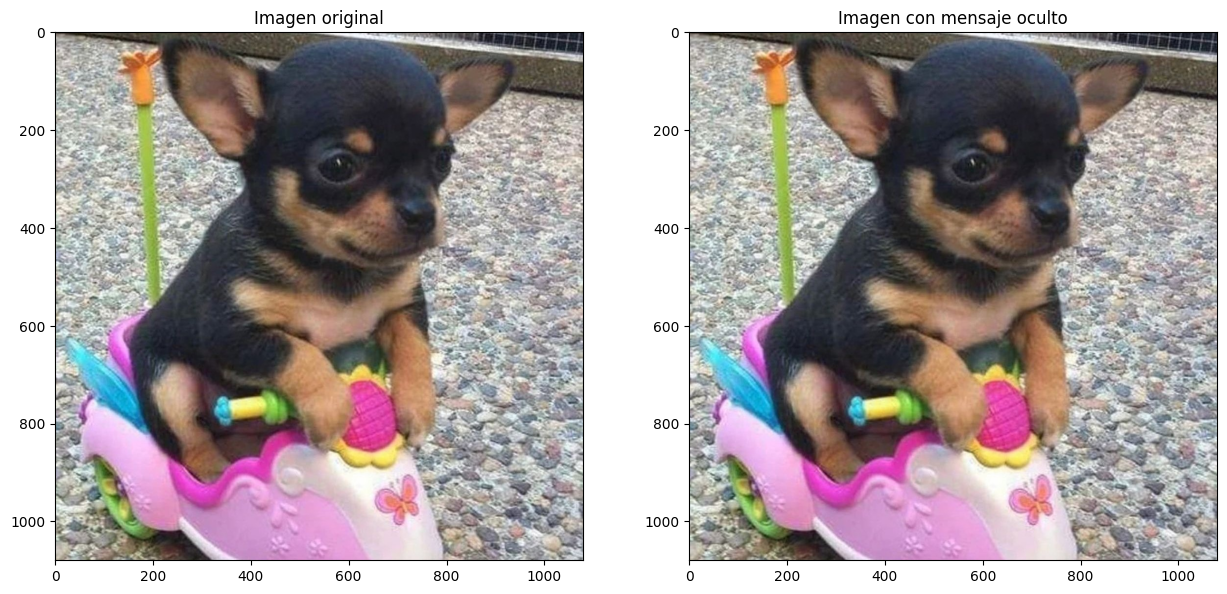

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,10))
ax[0].imshow(img)
ax[1].imshow(encoded_msg)

ax[0].set_title("Imagen original")
ax[1].set_title("Imagen con mensaje oculto")

plt.show()

Como podemos ver, ambas fotos parecen identicas a pesar de que la de la derecha contiene el mensaje oculto

# Ocultar imagen dentro de otra imagen
Tambien se podria codificar una imagen dentro de otra más grande, dado a que para representar cada pixel de la imagen que queremos ocultar necesitamos 9 pixeles de la otra imagen, es decir, debe ser 9 veces más chica.

Vamos a probar ocultando la imagen del primer perrito en otra imagen más grande de un burro:

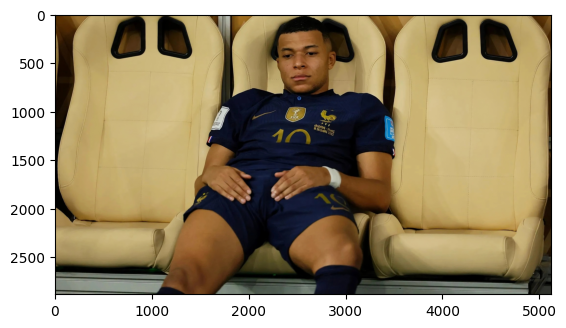

In [8]:
# Cargamos foto
img2 = cv2.imread("img2.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()

Vamos a seguir la misma logica con la diferencia que en lugar de interpretar los 8 bits que formamos con los 3 pixeles como un caracter, lo vamos a interpretar como un numero entero del 0 al 255, siendo dicho numero el valor que toma uno de los canales para un pixel dado. Entonces, vamos a tener que aplicar ligeras modificaciones a las dos funciones anteriores

In [9]:
# Funcion que codifica la imagen
def encode_img(msg, img):
    max_len = math.floor(img.shape[0]*img.shape[1]/3)
    
    if len(msg) > max_len:
        print("Error: message is too long")
        return
    
    np_img = np.array(img)
    pixels = np_img.reshape((np_img.shape[0]*np_img.shape[1],3))

    # Recorremos de a 3 pixeles
    for idx_pixel_set in range(math.floor(len(pixels)/3)):
        if idx_pixel_set == len(msg):
            break
        
        value = msg[idx_pixel_set]
        value_bin = f"{value:8b}"
            
        # Recorremos los 3 pixeles del set
        for i in range(3):
            # Recorremos los 3 canales de cada pixel
            for j in range(3):
                curr_px_ch = pixels[idx_pixel_set*3 + i, j]
                idx_value = 3*i+j
                
                #Si es el noveno valor, chequeamos si el mensaje termina, si no es el noveno seteamos el valor
                #del del canal en cuestion como par o impar segun si corresponde un 0 o 1 respectivamente
                if idx_value == 8:
                    pixels[idx_pixel_set*3 + i, j] = update_last_pixel_channel(curr_px_ch, idx_pixel_set==len(msg)-1)
                else:
                    curr_bit = value_bin[3*i+j]
                    pixels[idx_pixel_set*3 + i, j] = update_pixel_channel(curr_px_ch, int(curr_bit) if curr_bit!=" " else 0)
    
    return pixels.reshape(img.shape)

#Funcion que decodifica la imagen
def decode_img(img):
    np_img = np.array(img)
    pixels = np_img.reshape((np_img.shape[0]*np_img.shape[1],3))
    
    msg = []
    done=False
    # Recorremos de a 3 pixeles
    curr_char_bin = ''

    for i_px,pixel in enumerate(pixels):
        if done: break
        for i_ch,channel in enumerate(pixel):
            if (i_px+1)%3==0 and i_ch==2:
                if channel%2==0: done=True
                else: pass
            else:
                if channel%2==0: curr_char_bin+='0'
                else: curr_char_bin+='1'
        if (i_px+1)%3==0:
            msg.append(int(curr_char_bin,2))
            curr_char_bin = ''
            
    return np.array(msg)

## Encoding

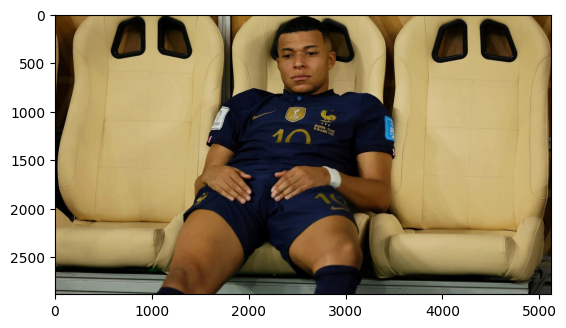

In [10]:
#Pasamos como mensaje un array con los valores de la foto del perrito
encoded_img = encode_img(img.flatten(), img2.copy())
plt.imshow(encoded_img)
plt.show()

## Decoding

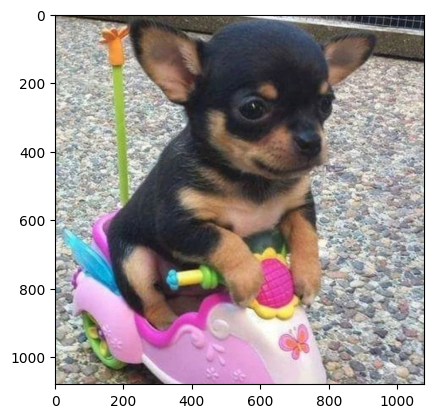

In [11]:
# Decodificamos la imagen
decoded_img = decode_img(encoded_img)

# Le hacemos reshape, ya conociendo de antemano la resolucion dado a que conocemos la imagen oculta
# De lo contrario, podemos también codiifcar la resolucion ademas de los pixeles de la imagen
decoded_img = decoded_img.reshape(img.shape)
plt.imshow(decoded_img)
plt.show()

## Comparacion entre imagen original y codificada

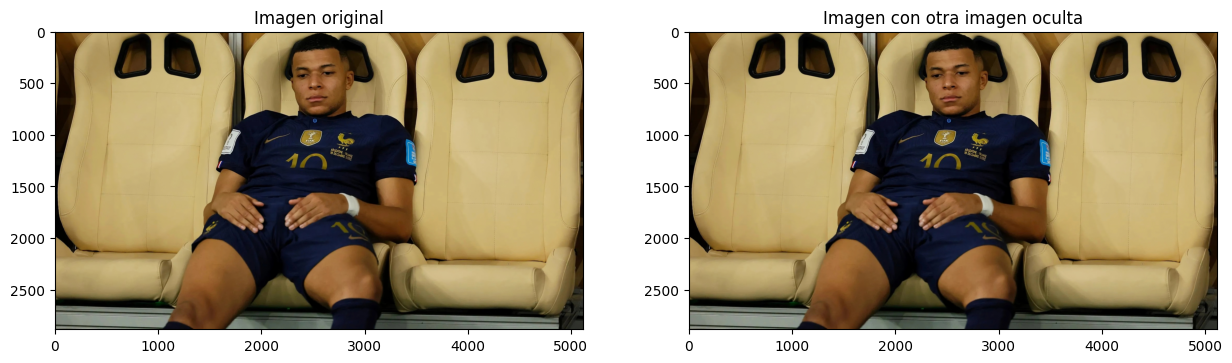

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,10))
ax[0].imshow(img2)
ax[1].imshow(encoded_img)

ax[0].set_title("Imagen original")
ax[1].set_title("Imagen con otra imagen oculta")

plt.show()

Como podemos ver, ambas fotos son iguales a simple vista a pesar de que la de la derecha contiene la imagen oculta